In [56]:

from numpy import *
import os
#from pylab import *
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random

import numpy as np
%config IPCompleter.greedy=True


In [57]:
import tensorflow as tf

from caffe_classes import class_names

train_x = zeros((1, 227,227,3)).astype(float32)
train_y = zeros((1, 1000))
xdim = train_x.shape[1:]
ydim = train_y.shape[1]


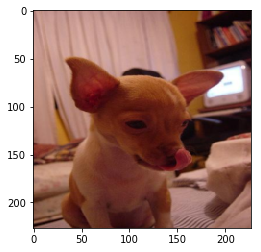

In [66]:
#Preprocessing

im1 = imread("n02085620_2188.JPEG")
# plt.imshow(im1)
# print(im1.shape)


im1=imresize(im1,(227,227,3),interp='bilinear')       
plt.imshow(im1)

im1=(im1[:,:,:3]).astype(float32)
im1 = im1 - mean(im1)
im1[:, :, 0], im1[:, :, 2] = im1[:, :, 2], im1[:, :, 0]

im2 = imread("n02085620_368.JPEG")
im2=imresize(im2,(227,227,3),interp='bilinear')    
#plt.imshow(im2)

im2=(im2[:,:,:3]).astype(float32)
im2 = im2 - mean(im2)
im2[:, :, 0], im2[:, :, 2] = im2[:, :, 2], im2[:, :, 0]
plt.show()


In [63]:
net_data = load(open("bvlc_alexnet.npy", "rb"), encoding="latin1").item()
#net_data = load("bvlc_alexnet.npy").item()

def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):
    '''From https://github.com/ethereon/caffe-tensorflow
    '''
    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
    
    
    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups =  tf.split(input, group, 3)   #tf.split(3, group, input)
        kernel_groups = tf.split(kernel, group, 3)  #tf.split(3, group, kernel) 
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(output_groups, 3)          #tf.concat(3, output_groups)
    return  tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])



x = tf.placeholder(tf.float32, (None,) + xdim)


In [64]:
k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4
conv1W = tf.Variable(net_data["conv1"][0])
conv1b = tf.Variable(net_data["conv1"][1])
conv1_in = conv(x, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
conv1 = tf.nn.relu(conv1_in)

#lrn1
#lrn(2, 2e-05, 0.75, name='norm1')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn1 = tf.nn.local_response_normalization(conv1,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias)

#maxpool1
#max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)


#conv2
#conv(5, 5, 256, 1, 1, group=2, name='conv2')
k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
conv2W = tf.Variable(net_data["conv2"][0])
conv2b = tf.Variable(net_data["conv2"][1])
conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv2 = tf.nn.relu(conv2_in)


#lrn2
#lrn(2, 2e-05, 0.75, name='norm2')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn2 = tf.nn.local_response_normalization(conv2,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias)

#maxpool2
#max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#conv3
#conv(3, 3, 384, 1, 1, name='conv3')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
conv3W = tf.Variable(net_data["conv3"][0])
conv3b = tf.Variable(net_data["conv3"][1])
conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv3 = tf.nn.relu(conv3_in)

#conv4
#conv(3, 3, 384, 1, 1, group=2, name='conv4')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
conv4W = tf.Variable(net_data["conv4"][0])
conv4b = tf.Variable(net_data["conv4"][1])
conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv4 = tf.nn.relu(conv4_in)


#conv5
#conv(3, 3, 256, 1, 1, group=2, name='conv5')
k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
conv5W = tf.Variable(net_data["conv5"][0])
conv5b = tf.Variable(net_data["conv5"][1])
conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv5 = tf.nn.relu(conv5_in)

#maxpool5
#max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#fc6
#fc(4096, name='fc6')
fc6W = tf.Variable(net_data["fc6"][0])
fc6b = tf.Variable(net_data["fc6"][1])
fc6 = tf.nn.relu_layer(tf.reshape(maxpool5, [-1, int(prod(maxpool5.get_shape()[1:]))]), fc6W, fc6b)

#fc7
#fc(4096, name='fc7')
fc7W = tf.Variable(net_data["fc7"][0])
fc7b = tf.Variable(net_data["fc7"][1])
fc7 = tf.nn.relu_layer(fc6, fc7W, fc7b)

#fc8
#fc(1000, relu=False, name='fc8')
fc8W = tf.Variable(net_data["fc8"][0])
fc8b = tf.Variable(net_data["fc8"][1])
fc8 = tf.nn.xw_plus_b(fc7, fc8W, fc8b)


#prob
#softmax(name='prob'))
prob = tf.nn.softmax(fc8)


In [65]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

t = time.time()
output = sess.run(prob, feed_dict = {x:np.array([im1,im2])})
################################################################################

#Output:


for input_im_ind in range(output.shape[0]):
    inds = argsort(output)[input_im_ind,:]
    print("Image", input_im_ind)
    for i in range(5):
        print(class_names[inds[-1-i]], output[input_im_ind, inds[-1-i]])

print(time.time()-t)

Image 0
pot, flowerpot 0.148983
bell pepper 0.0957239
vine snake 0.0945738
vase 0.044678
American chameleon, anole, Anolis carolinensis 0.041198
Image 1
Chihuahua 0.244518
Mexican hairless 0.0899614
Boston bull, Boston terrier 0.0664757
toy terrier 0.0474877
Italian greyhound 0.038392
10.299269199371338
